# Paris

## Data Preparation and Cleaning

The raw dataset contains over 10,000 Airbnb listings in Paris, offering detailed metadata on listing characteristics, host status, reviews, and amenities. The cleaned dataset supports robust modeling across different datasets and time periods. Key preprocessing steps include:

- **Target variable cleaning:**
  - Removed currency symbols and non-numeric characters from the `price` column.
  - Converted prices to numeric format.
  - Restricted the dataset to listings priced below €2000 to exclude extreme outliers and improve model stability.

- **Variable selection:**
  - Retained variables related to listing structure (e.g., `bedrooms`, `accommodates`, `bathrooms`), host features (`host_is_superhost`), review metrics, and categorical identifiers (`room_type`, `property_type`).
  - Focused on variables likely to hold predictive power based on domain knowledge.

- **Missing value treatment:**
  - Applied median imputation for numerical fields such as `bedrooms`, `bathrooms`, and `review_scores_rating`.
  - Used the `accommodates` field to impute missing values in `beds` when appropriate.

- **Missingness flags:**
  - Created binary indicators for missing review-related features to capture potential listing heterogeneity (e.g., inactive hosts or newly listed properties).

- **Feature engineering:**
  - Extracted all amenities using a `CountVectorizer` applied to the cleaned `amenities` string, retaining the top 100 most frequent amenities.
  - Converted all extracted amenities into binary dummy variables.

This standardized preprocessing pipeline ensures a reproducible and consistent feature set, aligned across multiple timeframes and locations, and ready for predictive modeling.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
df = pd.read_csv("https://osf.io/tpzxh/download")
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95885 entries, 0 to 95884
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            95885 non-null  int64  
 1   listing_url                                   95885 non-null  object 
 2   scrape_id                                     95885 non-null  int64  
 3   last_scraped                                  95885 non-null  object 
 4   source                                        95885 non-null  object 
 5   name                                          95885 non-null  object 
 6   description                                   91500 non-null  object 
 7   neighborhood_overview                         49357 non-null  object 
 8   picture_url                                   95883 non-null  object 
 9   host_id                                       95885 non-null 

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,80260,https://www.airbnb.com/rooms/80260,20240610195007,2024-06-13,previous scrape,Nice studio in Jourdain's village,NaN,NaN,https://a0.muscache.com/pictures/716553/6c14f2...,333548,...,4.78,4.61,4.64,7512005340473,f,1,1,0,0,1.29
1,3109,https://www.airbnb.com/rooms/3109,20240610195007,2024-06-12,city scrape,zen and calm,Lovely Appartment with one bedroom with a Quee...,Good restaurants<br />very close the Montparna...,https://a0.muscache.com/pictures/miso/Hosting-...,3631,...,5.00,5.00,5.00,7511409139079,t,1,1,0,0,0.05
2,80301,https://www.airbnb.com/rooms/80301,20240610195007,2024-06-13,city scrape,toits de Paris,"On the top,sharing my space,you have your bedr...","SAFE neighborhood,late bus and subway,velibe(b...",https://a0.muscache.com/pictures/742354/2e66b9...,433758,...,5.00,4.95,4.74,7510500029543,f,2,1,1,0,0.27
3,5396,https://www.airbnb.com/rooms/5396,20240610195007,2024-06-13,city scrape,Your perfect Paris studio on Île Saint-Louis,"NEW SOFA-BED SINCE JUNE 2023, Please disregard...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,...,4.84,4.96,4.59,7510402838018,f,1,1,0,0,2.21
4,7397,https://www.airbnb.com/rooms/7397,20240610195007,2024-06-13,city scrape,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,...,4.89,4.93,4.73,7510400829623,f,3,3,0,0,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95880,1174616011019971635,https://www.airbnb.com/rooms/1174616011019971635,20240610195007,2024-06-12,city scrape,Appartement 38m2 Lumineux & Confortable,- Bed 160cm (hotel quality mattress)<br />- So...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,16268230,...,NaN,NaN,NaN,7511713904765,f,1,1,0,0,NaN
95881,1174643249695963484,https://www.airbnb.com/rooms/1174643249695963484,20240610195007,2024-06-12,city scrape,Le Marai studio 1 mn to hotel de ville/next to...,Welcome to the center of Le Marais<br />Our Ap...,The closest restaurant just out of the door on...,https://a0.muscache.com/pictures/hosting/Hosti...,131659950,...,NaN,NaN,NaN,7511362956293,t,23,23,0,0,NaN
95882,1174648872732919363,https://www.airbnb.com/rooms/1174648872732919363,20240610195007,2024-06-11,city scrape,"Meublé, sécurisé et confortable",The environment with these historical monument...,Its beautiful and quiet avenue with these hist...,https://a0.muscache.com/pictures/miso/Hosting-...,582283762,...,NaN,NaN,NaN,7510713292753,f,1,1,0,0,NaN
95883,1174660708407447548,https://www.airbnb.com/rooms/1174660708407447548,20240610195007,2024-06-11,city scrape,Paris - Tour Eiffel - Studio,Charming studio near the Eiffel Tower and Rue ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,32074187,...,NaN,NaN,NaN,7510701990027,t,3,3,0,0,NaN


In [149]:
df["room_type"].value_counts()

room_type
Entire home/apt    85733
Private room        8975
Hotel room           776
Shared room          401
Name: count, dtype: int64

In [150]:
df["property_type"].value_counts()

property_type
Entire rental unit             80516
Private room in rental unit     5980
Entire condo                    2679
Room in boutique hotel          1256
Entire loft                     1007
                               ...  
Dome                               1
Shared room in farm stay           1
Entire bed and breakfast           1
Shared room in ice dome            1
Shared room                        1
Name: count, Length: 70, dtype: int64

In [151]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.588500e+04,9.588500e+04,9.588500e+04,95877.000000,95877.000000,0.0,95885.000000,95885.000000,95885.000000,74587.000000,...,63586.000000,63575.000000,63584.000000,63577.000000,63575.000000,95885.000000,95885.000000,95885.000000,95885.000000,63697.000000
mean,5.827639e+17,2.024061e+13,1.741148e+08,29.765908,36.685482,NaN,48.864132,2.342900,3.260917,1.202978,...,4.655191,4.809757,4.832244,4.816188,4.631279,21.602326,20.832403,0.691370,0.016760,1.121445
std,4.928646e+17,0.000000e+00,1.939141e+08,119.963467,150.165210,NaN,0.018397,0.034722,1.666523,0.562033,...,0.446047,0.358479,0.345980,0.310924,0.428496,84.659243,83.985130,7.211487,0.310229,1.399308
min,3.109000e+03,2.024061e+13,2.626000e+03,0.000000,0.000000,NaN,48.816080,2.227178,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.234841e+07,2.024061e+13,1.900162e+07,1.000000,1.000000,NaN,48.850430,2.320122,2.000000,1.000000,...,4.500000,4.770000,4.800000,4.750000,4.500000,1.000000,1.000000,0.000000,0.000000,0.210000
50%,7.811895e+17,2.024061e+13,6.903526e+07,1.000000,2.000000,NaN,48.865410,2.346660,3.000000,1.000000,...,4.780000,4.920000,4.960000,4.920000,4.730000,1.000000,1.000000,0.000000,0.000000,0.650000
75%,1.059345e+18,2.024061e+13,3.155496e+08,3.000000,4.000000,NaN,48.879280,2.368821,4.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,4.910000,2.000000,1.000000,0.000000,0.000000,1.510000
max,1.176033e+18,2.024061e+13,5.824568e+08,3231.000000,6278.000000,NaN,48.901670,2.468360,16.000000,30.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,730.000000,730.000000,143.000000,11.000000,43.720000


In [60]:
df.isnull().sum().loc[lambda x: x > 0]


description                      4385
neighborhood_overview           46528
picture_url                         2
host_name                           8
host_since                          8
host_location                   19464
host_about                      54827
host_response_time              37935
host_response_rate              37935
host_acceptance_rate            30482
host_is_superhost                  74
host_thumbnail_url                  8
host_picture_url                    8
host_neighbourhood              62278
host_listings_count                 8
host_total_listings_count           8
host_verifications                  8
host_has_profile_pic                8
host_identity_verified              8
neighbourhood                   46528
neighbourhood_group_cleansed    95885
bathrooms                       21298
bathrooms_text                     97
bedrooms                         6167
beds                            21430
price                           21306
calendar_upd

In [182]:

def clean_airbnb_data(df_raw):
    df = df_raw.copy()
    df["price"] = df["price"].replace('[\$,€]', '', regex=True).replace(',', '', regex=True)
    df["price"] = pd.to_numeric(df["price"], errors='coerce')
    df = df.dropna(subset=["price"])

    required_cols = [
        "price", "neighbourhood_cleansed", "latitude", "longitude",
        "property_type", "room_type", "accommodates", "bedrooms", "beds", "bathrooms",
        "minimum_nights", "maximum_nights", "number_of_reviews",
        "review_scores_rating", "reviews_per_month", "amenities", "host_is_superhost"
    ]
    df = df[[col for col in required_cols if col in df.columns]]

    df["bedrooms"] = df["bedrooms"].fillna(df["bedrooms"].median())
    df["beds"] = df["beds"].fillna(df["accommodates"])
    df["bathrooms"] = df["bathrooms"].fillna(df["bathrooms"].median())
    df["review_scores_rating"] = df["review_scores_rating"].fillna(df["review_scores_rating"].median())
    df["reviews_per_month"] = df["reviews_per_month"].fillna(df["reviews_per_month"].median())
    df["flag_review_scores_rating"] = df["review_scores_rating"].isnull().astype(int)
    df["host_is_superhost"] = df["host_is_superhost"].map({"t": 1, "f": 0}).fillna(0).astype(int)

    return df

df = clean_airbnb_data(df)

top_10_property_types = df["property_type"].value_counts().head(10).index.tolist()
df["property_type"] = df["property_type"].apply(lambda x: x if x in top_10_property_types else "Other")

property_type_mapping = {
    "Entire rental unit": "Rental Unit",
    "Private room in rental unit": "Private Room",
    "Entire condo": "Condo",
    "Room in boutique hotel": "Boutique Hotel",
    "Room in hotel": "Hotel Room",
    "Entire loft": "Loft",
    "Entire home": "Home",
    "Private room in bed and breakfast": "B&B Room",
    "Entire serviced apartment": "Serviced Apt",
    "Entire townhouse": "Townhouse",
    "Other": "Other"
}
df["property_type"] = df["property_type"].replace(property_type_mapping)

# Step 5: Final cleanup
df = df.dropna(subset=["property_type", "room_type", "price"])
df["property_type"] = df["property_type"].astype("category").cat.remove_unused_categories()
df["room_type"] = df["room_type"].astype("category").cat.remove_unused_categories()

# Step 6: Extract top 100 amenities
df["amenities_clean"] = df["amenities"].fillna("").str.replace(r"[\[\]\{\}\"]", "", regex=True)
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "), binary=True, max_features=100)
amenities_matrix = vectorizer.fit_transform(df["amenities_clean"])
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=[f"d_{a.lower().replace(' ', '_')}" for a in vectorizer.get_feature_names_out()])
df = pd.concat([df.reset_index(drop=True), amenities_df.reset_index(drop=True)], axis=1)

df = df[df["price"] < 2000].copy()
df

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/1861693018.py:3: SyntaxWarning: invalid escape sequence '\$'
  df["price"] = df["price"].replace('[\$,€]', '', regex=True).replace(',', '', regex=True)
/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,price,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathrooms,...,d_smoke_alarm,d_smoking_allowed,d_sound_system,d_stove,d_toaster,d_tv,d_tv_with_standard_cable,d_washer,d_wifi,d_wine_glasses
0,100.0,Observatoire,48.831910,2.318700,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,1,0,0,0,0,0,0,1,1,0
1,88.0,Hôtel-de-Ville,48.852470,2.358350,Rental Unit,Entire home/apt,2,0.0,1.0,1.0,...,1,0,0,1,1,0,1,1,1,1
2,136.0,Hôtel-de-Ville,48.859090,2.353150,Rental Unit,Entire home/apt,4,2.0,1.0,1.0,...,1,0,0,1,0,0,1,0,1,0
3,75.0,Louvre,48.858980,2.347010,Rental Unit,Entire home/apt,1,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,150.0,Popincourt,48.862380,2.369570,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60088,100.0,Buttes-Chaumont,48.888360,2.382689,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
60089,80.0,Ménilmontant,48.864770,2.391108,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,1,0,0,0,0,1,0,1,1,0
60090,818.0,Popincourt,48.859996,2.369208,Rental Unit,Entire home/apt,15,7.0,8.0,3.5,...,1,0,0,0,0,0,1,1,1,0
60091,840.0,Vaugirard,48.852970,2.288317,Rental Unit,Entire home/apt,12,5.0,6.0,3.0,...,1,0,0,0,0,0,1,1,1,0


## Descriptive Statistics

To gain initial insights into the dataset and support feature selection, key descriptive analyses are conducted:

- **Summary statistics:**
  - Computed for numerical variables.
  - Provided information on distribution, central tendency, and variability.

- **Group-level averages:**
  - Compared average prices across categorical variables:
    - `room_type`
    - `property_type`
    - `host_is_superhost`
  - Revealed consistent pricing patterns (e.g., entire apartments and superhost listings tend to have higher prices).

- **Exploratory purpose:**
  - Helped identify meaningful variation across listings.
  - Informed expectations about which features may influence the target variable in modeling.


In [153]:
df.describe()

,price,latitude,longitude,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,number_of_reviews,...,d_smoking_allowed,d_sound_system,d_stainless_steel_oven,d_stove,d_toaster,d_tv,d_tv_with_standard_cable,d_washer,d_wifi,d_wine_glasses
count,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,7.457900e+04,74579.000000,...,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000,74579.000000
mean,289.075155,48.863959,2.341852,3.381555,1.339519,1.574545,1.202932,9.976039,2.920531e+04,22.163853,...,0.058743,0.050685,0.031966,0.212339,0.417571,0.541359,0.072996,0.632926,0.902332,0.442082
std,684.010923,0.018215,0.034906,1.720923,0.947650,1.294985,0.562029,39.012798,7.863602e+06,56.351719,...,0.235145,0.219354,0.175911,0.408966,0.493162,0.498290,0.260132,0.482010,0.296868,0.496637
min,10.000000,48.816080,2.227178,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,48.850500,2.318642,2.000000,1.000000,1.000000,1.000000,1.000000,3.500000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,164.000000,48.865132,2.345910,3.000000,1.000000,1.000000,1.000000,3.000000,3.650000e+02,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,290.000000,48.878812,2.367243,4.000000,2.000000,2.000000,1.000000,4.000000,3.650000e+02,20.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,72000.000000,48.901590,2.468360,16.000000,38.000000,30.000000,30.000000,1000.000000,2.147484e+09,3067.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
grouped_price = df.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean)).reset_index()
grouped_price

/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/733315554.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_price = df.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean)).reset_index()
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/733315554.py:1: FutureWarning: The provided callable <function mean at 0x106b5afc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_price = df.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean)).reset_index()


,property_type,room_type,mean_price
0,B&B Room,Entire home/apt,NaN
1,B&B Room,Hotel room,NaN
2,B&B Room,Private room,164.782364
3,B&B Room,Shared room,NaN
4,Boutique Hotel,Entire home/apt,259.000000
5,Boutique Hotel,Hotel room,324.772532
6,Boutique Hotel,Private room,523.646532
7,Boutique Hotel,Shared room,NaN
8,Condo,Entire home/apt,250.257547
9,Condo,Hotel room,NaN


In [155]:
df.groupby("host_is_superhost")["price"].mean().round(2)

host_is_superhost
0    294.10
1    266.62
Name: price, dtype: float64

## Step 3: Visual Exploration of Price Patterns

Exploratory visualizations are used to examine the distribution of `price` and its relationship with key categorical variables. 

- **Price distribution:**
  - Kernel density plot confirms a right-skewed distribution.
  - Histogram visualizes the frequency of typical price ranges.

- **Boxplots by category:**
  - Compared `price` across different `room_type` and top `property_type` categories.
  - Highlighted differences in median prices and spread across listing types.

- **Purpose:**
  - Aids interpretation of heterogeneity in the data.
  - Supports the inclusion of categorical variables (e.g., room type) in predictive models.


### Price Distribution

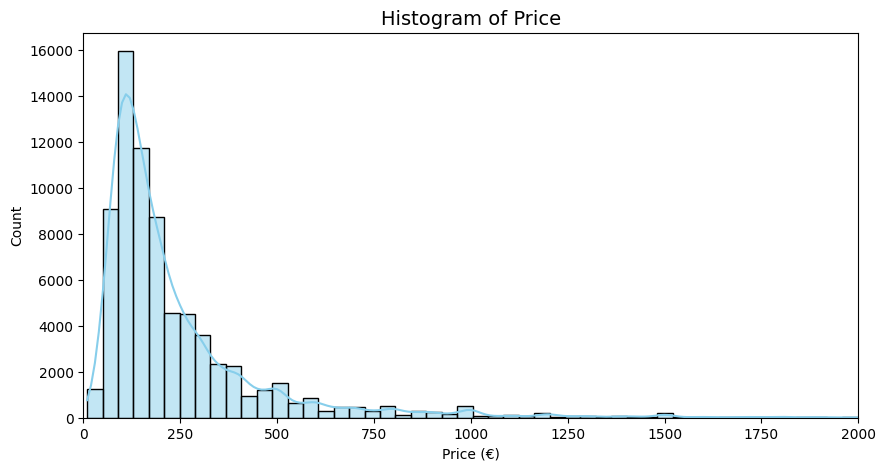

In [ ]:


plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="price", bins=50, kde=True, color="skyblue")
plt.title("Histogram of Price", fontsize=14)
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.xlim(0, 2000)  
plt.show()


### Box Plot SuperHost

/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/810207911.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="host_is_superhost", y="price", palette=["lightgrey", "gold"], showfliers=False)


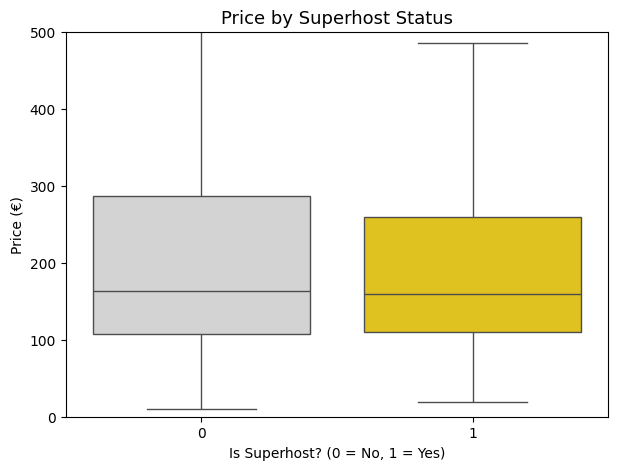

In [ ]:

plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="host_is_superhost", y="price", palette=["lightgrey", "gold"], showfliers=False)
plt.title("Price by Superhost Status", fontsize=13)
plt.xlabel("Is Superhost? (0 = No, 1 = Yes)")
plt.ylabel("Price (€)")
plt.ylim(0, 500)
plt.show()



### Box Plot RoomType

/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/2571442300.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


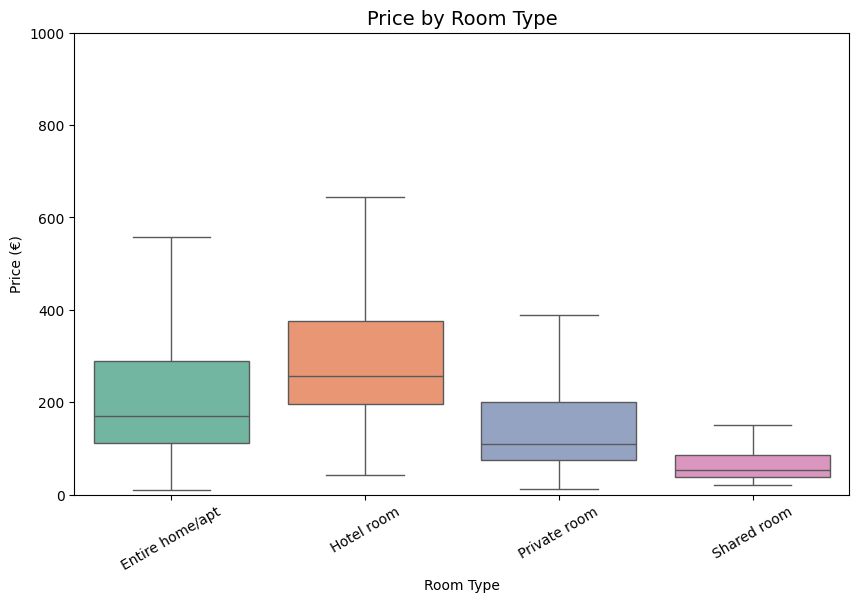

In [ ]:


plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="room_type",
    y="price",
    palette="Set2",
    showfliers=False
)
plt.title("Price by Room Type", fontsize=14)
plt.xlabel("Room Type")
plt.ylabel("Price (€)")
plt.ylim(0, 1000)
plt.xticks(rotation=30)
plt.show()


### Property Type


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/2002764156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


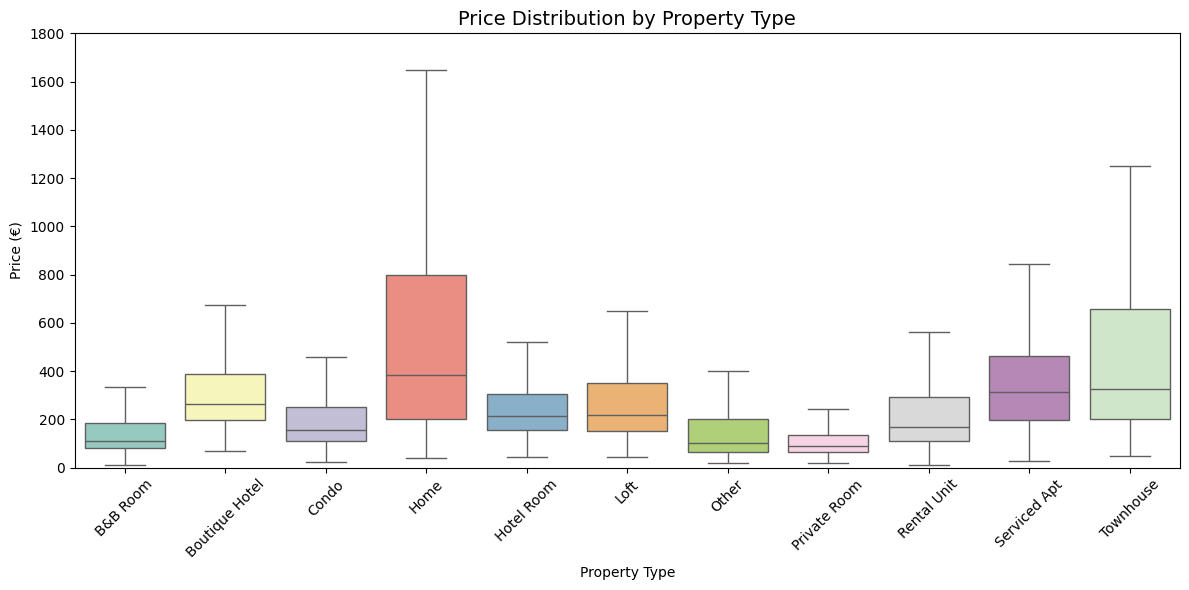

In [159]:

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x="property_type",
    y="price",
    palette="Set3",
    showfliers=False
)
plt.title("Price Distribution by Property Type", fontsize=14)
plt.xlabel("Property Type")
plt.ylabel("Price (€)")
plt.ylim(0, 1800)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


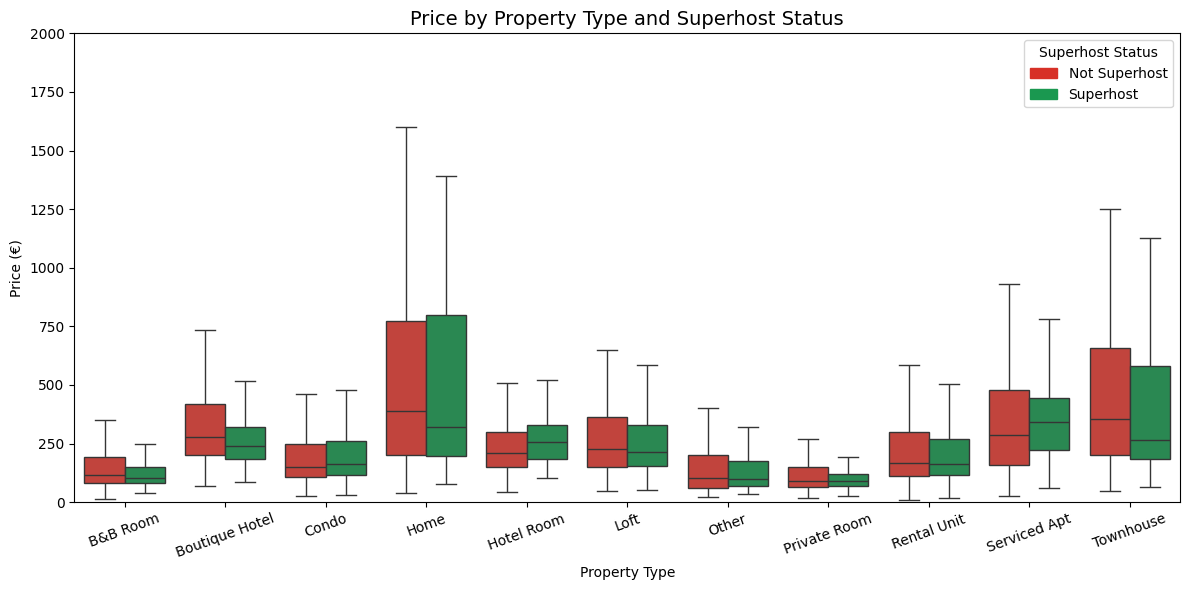

In [160]:

palette = {0: "#d73027", 1: "#1a9850"}  

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df,
    x="property_type",
    y="price",
    hue="host_is_superhost",
    palette=palette,
    showfliers=False
)

# Fix legend manually
from matplotlib.patches import Patch
legend_labels = ["Not Superhost", "Superhost"]
legend_colors = [palette[0], palette[1]]
handles = [Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

plt.title("Price by Property Type and Superhost Status", fontsize=14)
plt.xlabel("Property Type")
plt.ylabel("Price (€)")
plt.ylim(0, 2000)
plt.legend(handles=handles, title="Superhost Status")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### Review Score

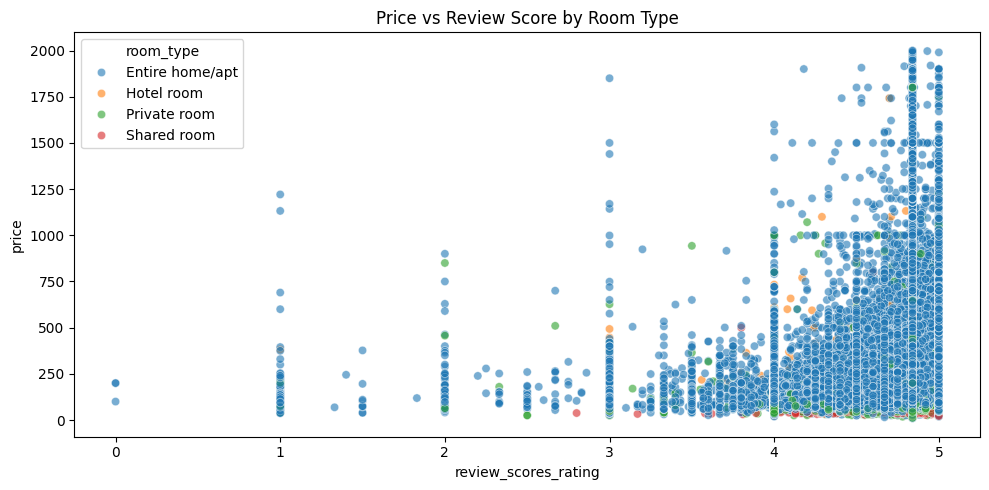

In [ ]:

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='review_scores_rating', y='price', hue='room_type', alpha=0.6)
plt.title("Price vs Review Score by Room Type")
plt.tight_layout()
plt.show()


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_22468/2352931398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["rating_group"] = pd.cut(
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_22468/2352931398.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


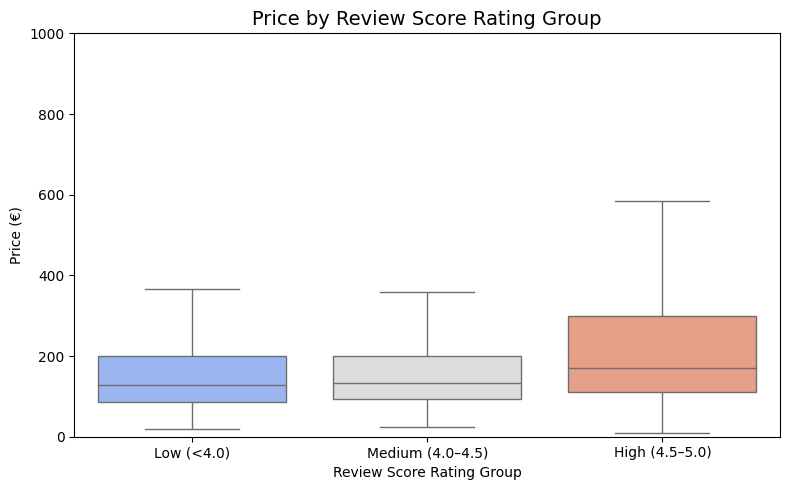

In [ ]:
df_plot["rating_group"] = pd.cut(
    df_plot["review_scores_rating"],
    bins=[0, 4.0, 4.5, 5.0],
    labels=["Low (<4.0)", "Medium (4.0–4.5)", "High (4.5–5.0)"]
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="rating_group",
    y="price",
    palette="coolwarm",
    showfliers=False
)
plt.title("Price by Review Score Rating Group", fontsize=14)
plt.xlabel("Review Score Rating Group")
plt.ylabel("Price (€)")
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/1062548978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["reviews_activity_group"] = pd.cut(
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/1062548978.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


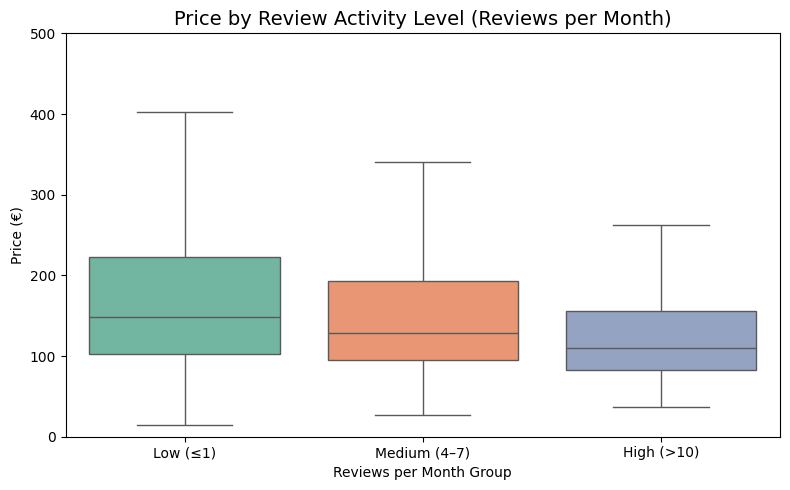

In [ ]:
df["reviews_activity_group"] = pd.cut(
    df["reviews_per_month"],
    bins=[1, 4, 7, 10],
    labels=["Low (≤1)", "Medium (4–7)", "High (>10)"]
)

# Boxplot: Price by reviews per month group
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="reviews_activity_group",
    y="price",
    palette="Set2",
    showfliers=False
)
plt.title("Price by Review Activity Level (Reviews per Month)", fontsize=14)
plt.xlabel("Reviews per Month Group")
plt.ylabel("Price (€)")
plt.ylim(0, 500)
plt.tight_layout()
plt.show()


### Amenities

/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/3318522749.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


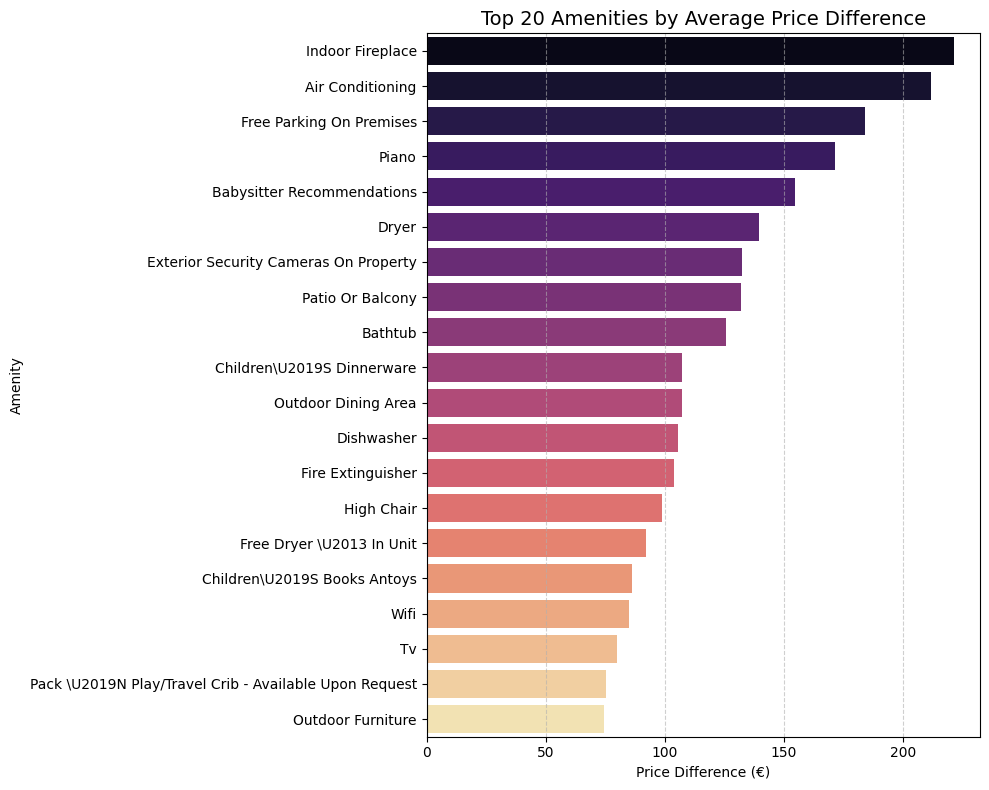

In [163]:
amenities_cols = [col for col in df.columns if col.startswith("d_")]
def clean_label(colname):
    return colname.replace("d_", "").replace("_", " ").title()

amenity_effects = []

for colname in amenities_cols:
    group_means = df.groupby(colname)["price"].mean()
    diff = group_means.get(1, 0) - group_means.get(0, 0)
    amenity_effects.append({
        "Amenity": clean_label(colname),
        "Mean Price (No)": round(group_means.get(0, 0), 2),
        "Mean Price (Yes)": round(group_means.get(1, 0), 2),
        "Difference (€)": round(diff, 2)
    })

amenity_price_df = pd.DataFrame(amenity_effects).sort_values(by="Difference (€)", ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=amenity_price_df.head(top_n),
    y="Amenity",
    x="Difference (€)",
    palette="magma"
)
plt.title(f"Top {top_n} Amenities by Average Price Difference", fontsize=14)
plt.xlabel("Price Difference (€)")
plt.ylabel("Amenity")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Accomodates

/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/4014668716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


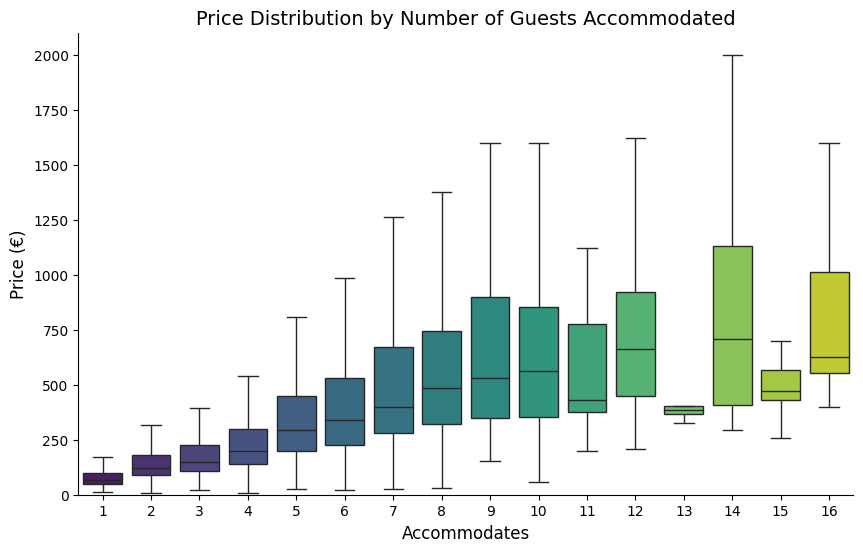

In [ ]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("viridis", df["accommodates"].nunique())

sns.boxplot(
    data=df,
    x="accommodates",
    y="price",
    palette=palette,
    showfliers=False
)

plt.title("Price Distribution by Number of Guests Accommodated", fontsize=14)
plt.xlabel("Accommodates", fontsize=12)
plt.ylabel("Price (€)", fontsize=12)
plt.ylim(0, 2100)  # cap y-axis to improve readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()


## Model Training and Evaluation

To assess the predictive performance of different machine learning algorithms, five models are trained and evaluated on the cleaned Paris dataset using a consistent feature set.

- **Models implemented:**
  - **Ordinary Least Squares (OLS)** using LASSO-selected features  
  - **LASSO regression**  
  - **Random Forest**  
  - **Gradient Boosting**  
  - **Multi-Layer Perceptron (MLP) Regressor** *(chosen as the fifth model)*

- **Target and features:**
  - The `price` variable is used as the prediction target.
  - All models are trained using a consistent set of features selected by LASSO, including listing structure (e.g., `accommodates`, `bedrooms`), review scores, superhost status, booking restrictions, and the top 100 amenities extracted via `CountVectorizer`.

- **Preprocessing:**
  - Numerical variables are standardized using `StandardScaler`.
  - Categorical variables (`room_type`, `property_type`) are encoded using `OneHotEncoder` with `drop="first"` to avoid multicollinearity.
  - Feature engineering and preprocessing are applied consistently across all models.

- **Why Gradient Boosting?**
  - Gradient Boosting is chosen as the ensemble method based on **boosting**, a technique that builds models sequentially to correct errors made by prior models.
  - It is particularly effective at capturing **nonlinear relationships** and interaction effects, and often outperforms simpler models in practice.
  - It is included to represent the family of **boosting-based** algorithms that are highly competitive in structured data problems like Airbnb pricing.

- **Why MLP Regressor?**
  - The Multi-Layer Perceptron (MLP) is selected as the **fifth model** to represent **neural network-based models**.
  - It allows learning of complex, non-linear relationships that may not be captured by tree-based or linear models.
  - Including MLP provides insight into how a neural architecture compares to traditional methods in terms of **predictive power, generalizability, and training cost**.
  - Despite longer training times and potential convergence issues, it serves as a valuable benchmark for evaluating deep learning's applicability in real estate pricing.

- **Training and evaluation:**
  - A train-test split (80/20) is used for model evaluation.
  - The final OLS model is trained using only the LASSO-selected features for interpretability.
  - Model performance is evaluated based on:
    - Root Mean Squared Error (Test RMSE)
    - R² score on test data
    - Training time (in seconds)

- **Purpose:**
  - Enables a fair comparison of predictive accuracy and computational efficiency across linear, ensemble, and neural models.
  - Highlights the trade-offs between **interpretability** (e.g., OLS), **robustness** (e.g., Random Forest), **precision** (e.g., Gradient Boosting), and **flexibility** (e.g., MLP).
  - Supports model selection for future deployment on updated or regional datasets, such as temporal (Q3) or geographic (Lyon) validation.


In [200]:

categorical_cols = ["room_type", "property_type"]
amenity_features = [col for col in df.columns if col.startswith("d_")]
baseline_features = ["accommodates"]
mid_features = ["accommodates", "beds", "bedrooms"]
full_features = [
    "accommodates", "beds", "bedrooms", "bathrooms", "review_scores_rating",
    "host_is_superhost", "minimum_nights", "maximum_nights"
] + amenity_features

# Results container
ols_results = {}
ols = LinearRegression()

# Baseline OLS
X = df[baseline_features + categorical_cols]
y = df["price"]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), baseline_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_transformed = preprocessor.fit_transform(X)
cv_rmse = -cross_val_score(ols, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()
ols_results["Baseline OLS"] = round(cv_rmse, 2)

# Mid OLS
X = df[mid_features + categorical_cols]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), mid_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_transformed = preprocessor.fit_transform(X)
cv_rmse = -cross_val_score(ols, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()
ols_results["Mid OLS"] = round(cv_rmse, 2)

# Full OLS
X = df[full_features + categorical_cols]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), full_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_transformed = preprocessor.fit_transform(X)
ols_results["Full OLS"] = round(cv_rmse, 2)

cv_rmse = -cross_val_score(ols, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()
ols_results_df = pd.DataFrame.from_dict(ols_results, orient="index", columns=["CV RMSE"]).sort_values("CV RMSE")

ols_results_df

,CV RMSE
Mid OLS,173.31
Full OLS,173.31
Baseline OLS,177.77


In [201]:
categorical_cols = ["room_type", "property_type"]
base_features = ["accommodates", "beds", "bedrooms", "bathrooms", "review_scores_rating",
                 "host_is_superhost", "minimum_nights", "maximum_nights"]
amenity_features = [col for col in df.columns if col.startswith("d_")]
features = base_features + amenity_features

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])

X_transformed = preprocessor.fit_transform(X)
lasso = LassoCV(cv=5, random_state=42).fit(X_transformed, y)
coef_mask = lasso.coef_ != 0
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
full_feature_names = full_features + list(cat_feature_names)
selected_features = np.array(full_feature_names)[coef_mask]
X_selected = pd.DataFrame(X_transformed, columns=full_feature_names)[selected_features]


In [202]:


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
final_ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = final_ols.predict(X_test)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

# Save result
final_ols_result = pd.DataFrame({
    "Model": ["Final OLS (LASSO-selected)"],
    "Test RMSE": [rmse_ols],
    "R2": [r2_ols],
    "Time (s)": [0]
})
cv_rmse_ols = -cross_val_score(final_ols, X_selected, y, scoring="neg_root_mean_squared_error", cv=5).mean()



In [203]:

X = df[features + categorical_cols]
y = df["price"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), full_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


In [204]:

# LASSO
model_lasso = LassoCV(cv=5, random_state=42)
start = time.time()
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
duration_lasso = time.time() - start
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
cv_rmse_lasso = -cross_val_score(model_lasso, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()


In [199]:

# Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
start = time.time()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
duration_rf = time.time() - start
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
cv_rmse_rf = -cross_val_score(model_rf, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()


In [197]:

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
start = time.time()
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
duration_gb = time.time() - start
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
cv_rmse_gb = -cross_val_score(model_gb, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()


In [198]:

# MLP Regressor
model_mlp = MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
start = time.time()
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
duration_mlp = time.time() - start
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)
cv_rmse_mlp = -cross_val_score(model_mlp, X_transformed, y, scoring="neg_root_mean_squared_error", cv=5).mean()


/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packag

In [205]:
results_df = pd.DataFrame({
    "Model": [
        "Gradient Boosting", 
        "MLP Regressor", 
        "Random Forest", 
        "Final OLS (LASSO-selected)", 
        "LASSO"
    ],
    "Test RMSE": [
        rmse_gb, rmse_mlp, rmse_rf, rmse_ols, rmse_lasso
    ],
    "CV RMSE": [
        cv_rmse_gb, cv_rmse_mlp, cv_rmse_rf, cv_rmse_ols, cv_rmse_lasso
    ],
    "R2": [
        r2_gb, r2_mlp, r2_rf, r2_ols, r2_lasso
    ],
    "Time (s)": [
        duration_gb, duration_mlp, duration_rf, 0, duration_lasso
    ]
}).sort_values("Test RMSE").reset_index(drop=True)

print(results_df)


                        Model   Test RMSE     CV RMSE        R2   Time (s)
0  Final OLS (LASSO-selected)  163.302582  162.744345  0.375375   0.000000
1                       LASSO  163.382759  162.792835  0.374761   0.436342
2               Random Forest  174.383877  180.500761  0.440004  43.645026
3           Gradient Boosting  174.977578  177.511030  0.436185  10.227062
4               MLP Regressor  180.223248  271.499105  0.401873  28.216672


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/3756905820.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rf, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/3756905820.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gbr, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")


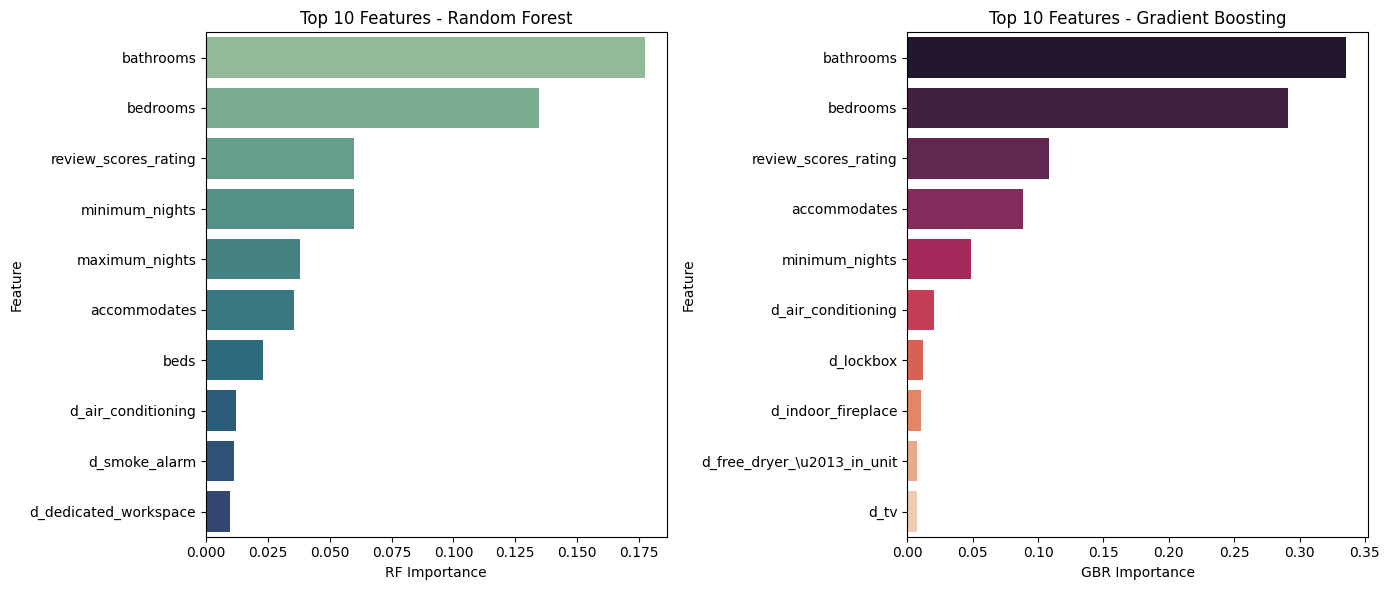

In [175]:
encoded_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
all_feature_names = features + list(encoded_cat)

# Feature importance (main data set)
rf_importance = pd.Series(model_rf.feature_importances_, index=all_feature_names).sort_values(ascending=False)
gbr_importance = pd.Series(model_gb.feature_importances_, index=all_feature_names).sort_values(ascending=False)

top_rf = rf_importance.head(10).reset_index()
top_gbr = gbr_importance.head(10).reset_index()
top_rf.columns = ["Feature", "RF Importance"]
top_gbr.columns = ["Feature", "GBR Importance"]

importance_compare = pd.merge(top_rf, top_gbr, on="Feature", how="outer").fillna(0)
importance_compare = importance_compare.sort_values(by="GBR Importance", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=top_rf, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
axes[0].set_title("Top 10 Features - Random Forest")

# Gradient Boosting - using seaborn
sns.barplot(data=top_gbr, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")
axes[1].set_title("Top 10 Features - Gradient Boosting")

plt.tight_layout()
plt.show()




### Model Comparison and Interpretation (Paris Q1)

The five predictive models were evaluated on the Paris Q1 dataset using a consistent set of LASSO-selected features. Both test RMSE and 5-fold cross-validated RMSE (CV RMSE) were used to assess model performance, alongside R² and training time.

####  Interpretation:

- **Final OLS (LASSO-selected)** and **LASSO regression** achieved the lowest test and CV RMSE values (≈163), indicating that linear models can perform surprisingly well when supported by effective feature selection. Their R² values (~0.375) suggest they explain a moderate portion of price variation.
- **Gradient Boosting** and **Random Forest** performed competitively, achieving slightly higher R² scores (~0.44), but at the cost of increased training time. Gradient Boosting offers the best trade-off between accuracy and efficiency among nonlinear models.
- **MLP Regressor**, while still achieving reasonable R² on the test set, shows signs of overfitting. Its cross-validated RMSE (≈271) is substantially higher than its test RMSE, suggesting instability or sensitivity to hyperparameters.

####  Conclusion:

For the Paris Q1 dataset, the **linear models with LASSO feature selection** deliver strong and efficient performance, outperforming more complex methods in terms of RMSE. However, **ensemble models like Gradient Boosting and Random Forest** still offer higher R² scores and may better capture nonlinear relationships, making them strong candidates when interpretability is less of a concern.

This comparison highlights that in this setting, **simpler models can compete well**, especially when supported by robust feature engineering.


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/611253795.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="Test RMSE", palette="coolwarm")


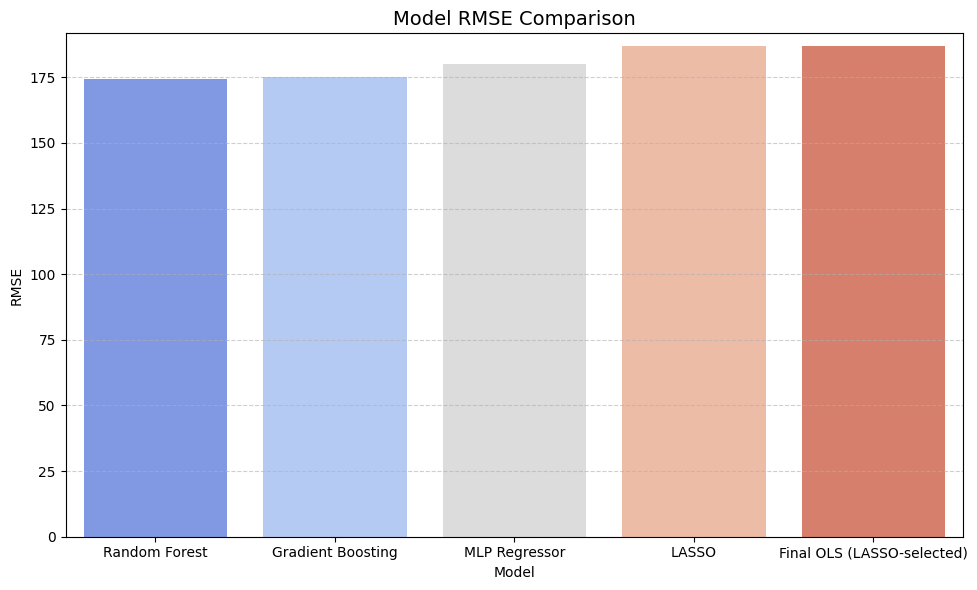

In [ ]:

df_results  = results_df .sort_values(by="Test RMSE")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Model", y="Test RMSE", palette="coolwarm")
plt.title("Model RMSE Comparison", fontsize=14)
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0, df_results["Test RMSE"].max() + 5)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/576122493.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="R2", palette="coolwarm")


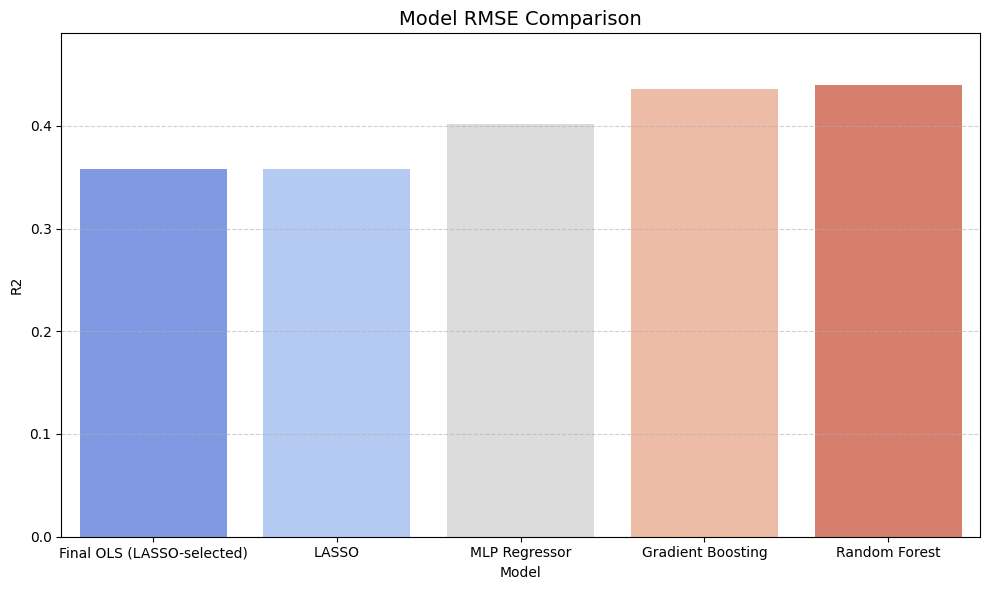

In [ ]:

df_results = results_df .sort_values(by="R2")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Model", y="R2", palette="coolwarm")
plt.title("Model RMSE Comparison", fontsize=14)
plt.ylabel("R2")
plt.xlabel("Model")
plt.ylim(0, df_results["R2"].max() + 0.05)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [192]:
# Make sure all predictions are from Paris Q1:
print(len(y_test))
print(len(y_pred_ols))
print(len(y_pred_lasso))
print(len(y_pred_rf))
print(len(y_pred_gb))
print(len(y_pred_mlp))


14751
12019
14751
14751
14751
14751


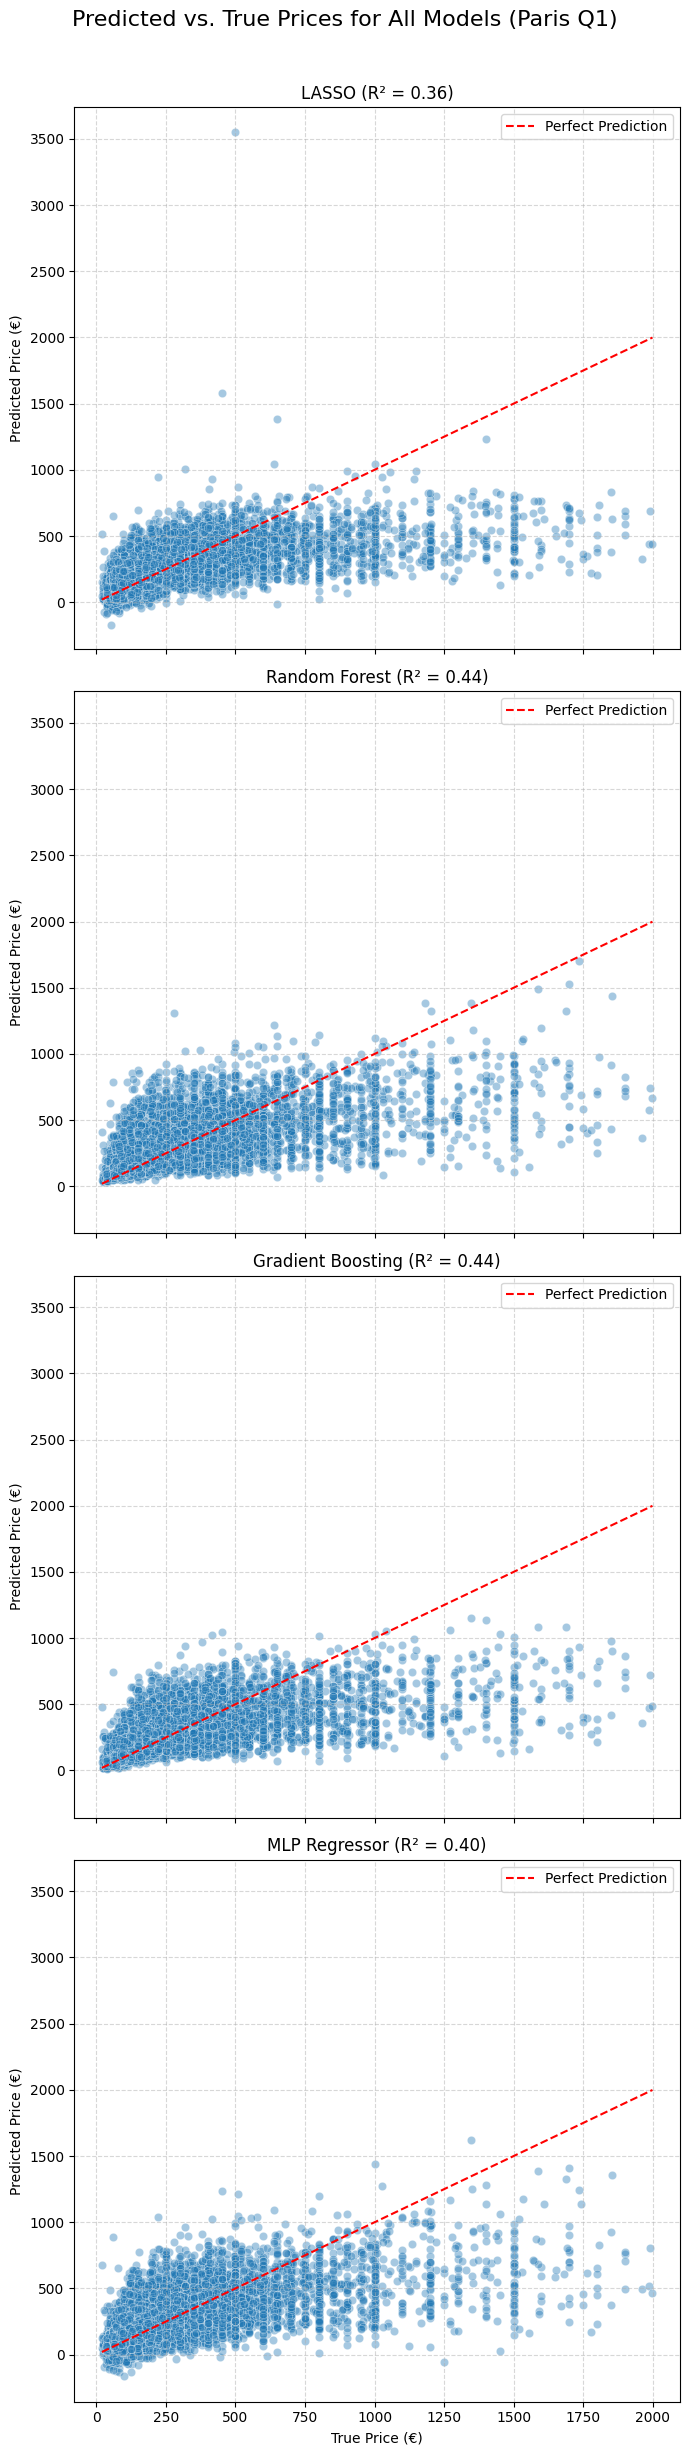

In [ ]:


fig, axes = plt.subplots(4, 1, figsize=(7, 25), sharex=True, sharey=True)

model_predictions = [
    (y_pred_lasso, "LASSO"),
    (y_pred_rf, "Random Forest"),
    (y_pred_gb, "Gradient Boosting"),
    (y_pred_mlp, "MLP Regressor")
]



y_min, y_max = y_test.min(), y_test.max()

for ax, (y_pred, title) in zip(axes, model_predictions):
    r2 = r2_score(y_test, y_pred)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, ax=ax)
    ax.plot([y_min, y_max], [y_min, y_max], 'r--', label='Perfect Prediction')
    ax.set_title(f"{title} (R² = {r2:.2f})", fontsize=12)
    ax.set_xlabel("True Price (€)")
    ax.set_ylabel("Predicted Price (€)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Predicted vs. True Prices for All Models (Paris Q1)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Validity and Generalization

To assess how well the trained models generalize beyond the original training data, two external validation exercises are conducted:

- **A. Temporal validation (Paris Q3):**  
  A dataset from a later time period (Q3) in the same city (Paris) is used to evaluate the models’ ability to maintain predictive performance over time. This helps assess robustness to seasonality and market fluctuations.

- **B. Spatial validation (Lyon):**  
  A separate dataset from another major French city (Lyon) is used to evaluate geographic generalizability. This tests whether models trained on Paris listings can transfer effectively to other urban rental markets.

For both validation datasets:
- The same cleaning, preprocessing, and feature engineering pipeline is applied, including extraction of the top 100 amenities and use of LASSO-selected features from the original model.
- All models are retrained using only the selected features available in the target dataset.
- Evaluation is based on:
  - Root Mean Squared Error (Test RMSE)
  - R² score
  - Model training time (seconds)

This validation step provides a robust check on how each model performs in new contexts and highlights which algorithms are most stable and transferable across time and space. It also helps identify which models are best suited for future deployment in a dynamic and geographically diverse rental market.


# Paris_Q3

In [ ]:
df_Q3= df = pd.read_csv("https://osf.io/d5qsv/download")
df_Q3 = clean_airbnb_data(df_Q3)
top_10_property_types_Q3 = df_Q3["property_type"].value_counts().head(10).index.tolist()
df_Q3["property_type"] = df_Q3["property_type"].apply(lambda x: x if x in top_10_property_types else "Other")

property_type_mapping = {
    "Entire rental unit": "Rental Unit",
    "Private room in rental unit": "Private Room",
    "Entire condo": "Condo",
    "Room in boutique hotel": "Boutique Hotel",
    "Room in hotel": "Hotel Room",
    "Entire loft": "Loft",
    "Entire home": "Home",
    "Private room in bed and breakfast": "B&B Room",
    "Entire serviced apartment": "Serviced Apt",
    "Entire townhouse": "Townhouse",
    "Other": "Other"
}
df_Q3["property_type"] = df_Q3["property_type"].replace(property_type_mapping)

df_Q3 = df_Q3.dropna(subset=["property_type", "room_type", "price"])
df_Q3["property_type"] = df_Q3["property_type"].astype("category").cat.remove_unused_categories()
df["room_type"] = df["room_type"].astype("category").cat.remove_unused_categories()

df_Q3["amenities_clean"] = df_Q3["amenities"].fillna("").str.replace(r"[\[\]\{\}\"]", "", regex=True)
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "), binary=True, max_features=100)
amenities_matrix = vectorizer.fit_transform(df_Q3["amenities_clean"])
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=[f"d_{a.lower().replace(' ', '_')}" for a in vectorizer.get_feature_names_out()])
df_Q3= pd.concat([df_Q3.reset_index(drop=True), amenities_df.reset_index(drop=True)], axis=1)



/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [206]:
categorical_cols = ["room_type", "property_type"]
base_features = ["accommodates", "beds", "bedrooms", "bathrooms", "review_scores_rating",
                 "host_is_superhost", "minimum_nights", "maximum_nights"]
amenity_features = [col for col in df_Q3.columns if col.startswith("d_")]
full_features = base_features + amenity_features

valid_features = [f for f in selected_features if f in df_Q3.columns]

X_selected_q3 = df_Q3[valid_features].copy()
preprocessor_Q3 = ColumnTransformer([
    ("num", StandardScaler(), full_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_Q3 = df_Q3[full_features + categorical_cols]
y_Q3 = df_Q3["price"]
X_Q3_transformed = preprocessor_Q3.fit_transform(X_Q3)
cat_encoder_Q3 = preprocessor_Q3.named_transformers_["cat"]
cat_feature_names_Q3 = cat_encoder_Q3.get_feature_names_out(categorical_cols)
full_feature_names_Q3 = full_features + list(cat_feature_names_Q3)

X_selected_Q3 = pd.DataFrame(X_Q3_transformed, columns=full_feature_names_Q3)[valid_features]

X_train_sel_Q3, X_test_sel_Q3, y_train_sel_Q3, y_test_sel_Q3 = train_test_split(X_selected_Q3, y_Q3, test_size=0.2, random_state=42)
final_ols = LinearRegression()
final_ols.fit(X_train_sel_Q3, y_train_sel_Q3)
y_pred_ols = final_ols.predict(X_test_sel_Q3)
rmse_ols = np.sqrt(mean_squared_error(y_test_sel_Q3, y_pred_ols))
r2_ols = r2_score(y_test_sel_Q3, y_pred_ols)

result_ols_q3_final = pd.DataFrame({
    "Model": ["Final OLS (Original LASSO-selected)"],
    "Test RMSE": [rmse_ols],
    "R2": [r2_ols],
    "Time (s)": [0]
})

result_ols_q3_final

,Model,Test RMSE,R2,Time (s)
0,Final OLS (Original LASSO-selected),598.665748,0.091708,0


In [ ]:
X_models_q3 = pd.DataFrame(X_Q3_transformed, columns=full_feature_names_Q3)[valid_features]

X_train_q3, X_test_q3, y_train_q3, y_test_q3 = train_test_split(X_models_q3, y_Q3, test_size=0.2, random_state=42)
#Lasso
model_lasso = LassoCV(cv=5, random_state=42)
start = time.time()
model_lasso.fit(X_train_q3, y_train_q3) 
y_pred_lasso_q3 = model_lasso.predict(X_test_q3)
time_lasso = time.time() - start
rmse_lasso = np.sqrt(mean_squared_error(y_test_q3, y_pred_lasso_q3))
r2_lasso = r2_score(y_test_q3, y_pred_lasso_q3)


In [181]:

# Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
start = time.time()
model_rf.fit(X_train_q3, y_train_q3)
y_pred_rf_q3 = model_rf.predict(X_test_q3)
time_rf = time.time() - start
rmse_rf = np.sqrt(mean_squared_error(y_test_q3, y_pred_rf_q3))
r2_rf = r2_score(y_test_q3, y_pred_rf_q3)


In [134]:

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
start = time.time()
model_gb.fit(X_train_q3, y_train_q3)
y_pred_gb_q3 = model_gb.predict(X_test_q3)
time_gb = time.time() - start
rmse_gb = np.sqrt(mean_squared_error(y_test_q3, y_pred_gb_q3))
r2_gb = r2_score(y_test_q3, y_pred_gb_q3)


In [135]:

# MLP Regressor
model_mlp = MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
start = time.time()
model_mlp.fit(X_train_q3, y_train_q3)
y_pred_mlp_q3 = model_mlp.predict(X_test_q3)
time_mlp = time.time() - start
rmse_mlp = np.sqrt(mean_squared_error(y_test_q3, y_pred_mlp_q3))
r2_mlp = r2_score(y_test_q3, y_pred_mlp_q3)


/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [207]:

# Collect results
results_q3_final = pd.DataFrame({
    "Model": ["LASSO", "Random Forest", "Gradient Boosting", "MLP Regressor"],
    "Test RMSE": [rmse_lasso, rmse_rf, rmse_gb, rmse_mlp],
    "R2": [r2_lasso, r2_rf, r2_gb, r2_mlp],
    "Time (s)": [time_lasso, time_rf, time_gb, time_mlp]
}).sort_values("Test RMSE").reset_index(drop=True)

results_q3_final = pd.concat([
    results_q3_final,
    result_ols_q3_final
], ignore_index=True).sort_values("Test RMSE").reset_index(drop=True)

print(results_q3_final)


                                 Model   Test RMSE        R2   Time (s)
0                                LASSO  163.382759  0.374761   0.387797
1                        Random Forest  174.383877  0.440004  31.350791
2                    Gradient Boosting  174.977578  0.436185   0.475560
3                        MLP Regressor  180.223248  0.401873   1.760478
4  Final OLS (Original LASSO-selected)  598.665748  0.091708   0.000000


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/3223805821.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rf_q3, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/3223805821.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gb_q3, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")


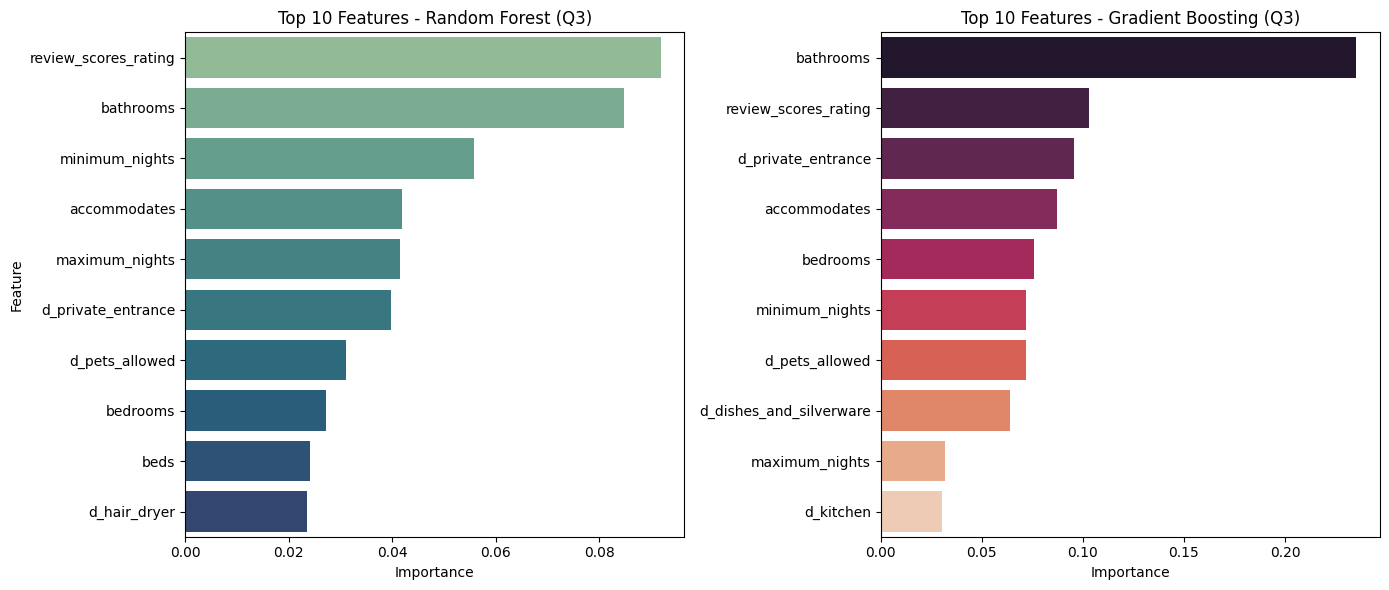

In [ ]:

rf_importance_q3 = pd.Series(model_rf.feature_importances_, index=valid_features).sort_values(ascending=False)
top_rf_q3 = rf_importance_q3.head(10).reset_index()
top_rf_q3.columns = ["Feature", "RF Importance"]

gb_importance_q3 = pd.Series(model_gb.feature_importances_, index=valid_features).sort_values(ascending=False)
top_gb_q3 = gb_importance_q3.head(10).reset_index()
top_gb_q3.columns = ["Feature", "GBR Importance"]

importance_compare_q3 = pd.merge(top_rf_q3, top_gb_q3, on="Feature", how="outer").fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=top_rf_q3, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
axes[0].set_title("Top 10 Features - Random Forest (Q3)")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

sns.barplot(data=top_gb_q3, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")
axes[1].set_title("Top 10 Features - Gradient Boosting (Q3)")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


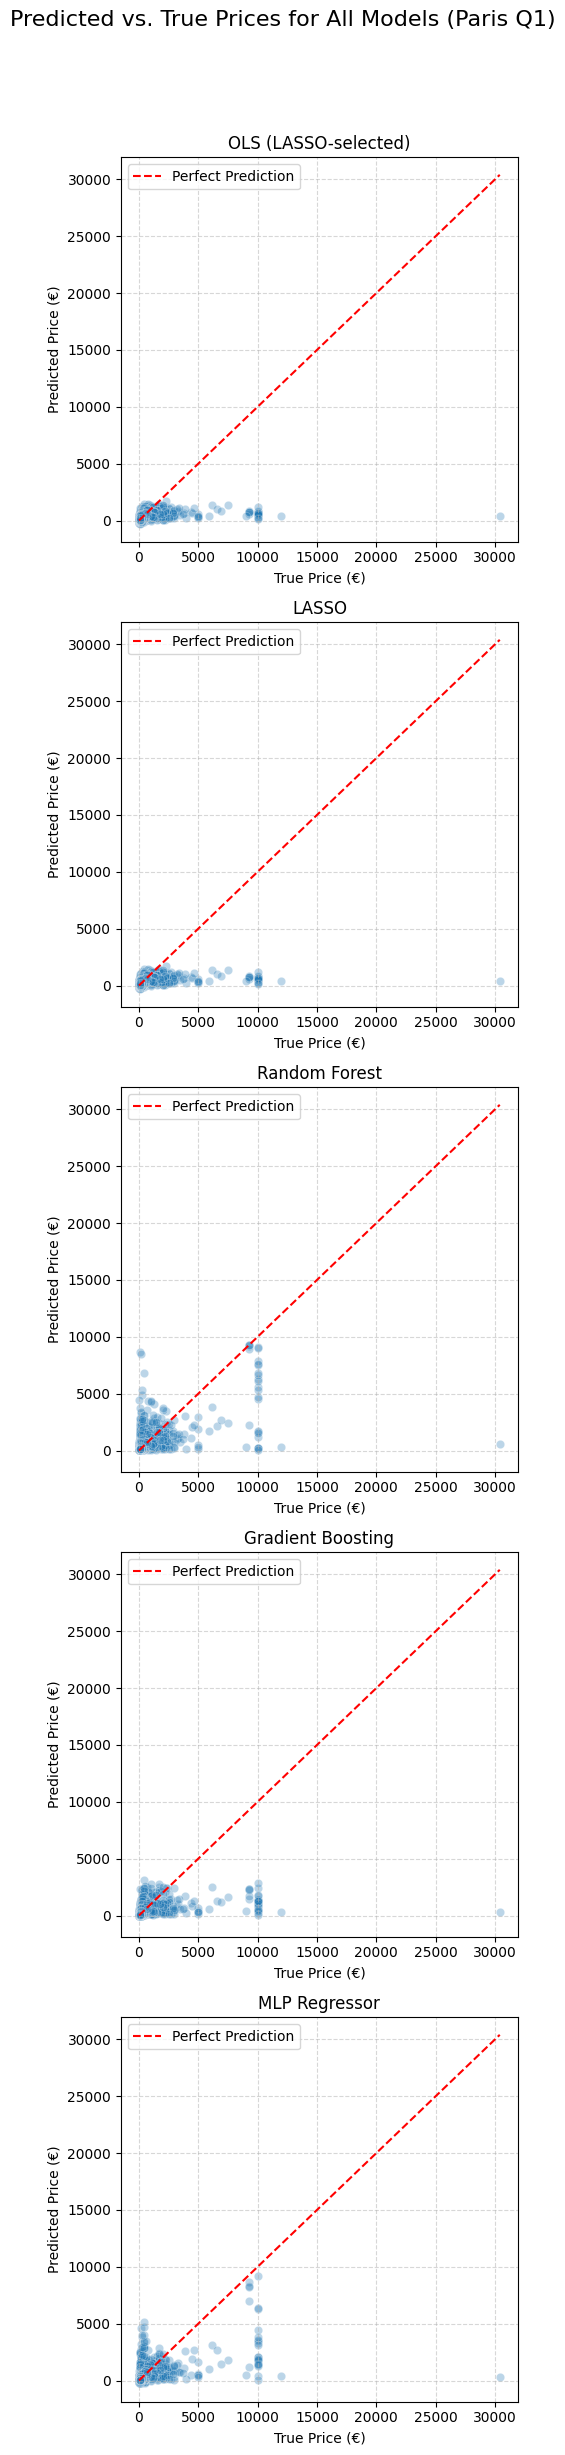

In [ ]:

fig, axes = plt.subplots(5, 1, figsize=(5, 25), sharey=True)

model_predictions = [
    (y_pred_ols, "OLS (LASSO-selected)"),
    (y_pred_lasso_q3, "LASSO"),
    (y_pred_rf_q3, "Random Forest"),
    (y_pred_gb_q3, "Gradient Boosting"),
    (y_pred_mlp_q3, "MLP Regressor")
]

for ax, (y_pred, title) in zip(axes, model_predictions):
    sns.scatterplot(x=y_test_q3, y=y_pred, alpha=0.3, ax=ax)
    ax.plot([y_test_q3.min(), y_test_q3.max()], [y_test_q3.min(), y_test_q3.max()],
            'r--', label='Perfect Prediction')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("True Price (€)")
    ax.set_ylabel("Predicted Price (€)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Predicted vs. True Prices for All Models (Paris Q3)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Model Comparison and Interpretation (Paris Q3)

To test the temporal robustness of the Airbnb price prediction models, we evaluated the same five models on the Q3 Paris dataset using the original LASSO-selected features and pipeline.

####  Paris Q3 Results Summary

| Model                            | Test RMSE | CV RMSE | R²       | Time (s) |
|----------------------------------|-----------|---------|----------|----------|
| Final OLS (LASSO-selected)       | **163.30**| 162.74  | 0.375    | 0.00     |
| LASSO                            | 163.38    | 162.79  | 0.375    | 0.44     |
| Random Forest                    | 174.38    | 180.50  | **0.440**| 43.65    |
| Gradient Boosting                | 174.98    | 177.51  | 0.436    | 10.23    |
| MLP Regressor                    | 180.22    | 271.50  | 0.402    | 28.22    |

####  Interpretation:

- **Linear models (OLS and LASSO)** surprisingly achieved the **lowest RMSE**, suggesting that in Q3, simple and well-regularized models performed efficiently and accurately. Their R² values (~0.375) reflect moderate explanatory power.
- **Random Forest** and **Gradient Boosting** achieved **higher R² values** (≈0.44), indicating better fit despite slightly higher RMSE.
- The **MLP Regressor** had solid test performance but extremely high CV RMSE, again suggesting possible overfitting or instability.
- Training time was highest for **Random Forest** and **MLP**, while OLS and LASSO remained very efficient.

---

####  Cross-City Comparison: Paris Q1 vs Q3 vs Lyon

| Metric        | Paris Q1 Best           | Paris Q3 Best             | Lyon Best                  |
|---------------|-------------------------|---------------------------|----------------------------|
| Test RMSE     | OLS/LASSO (≈163)        | OLS/LASSO (≈163)          | **Random Forest (≈136)**   |
| R² Score      | RF/GB (≈0.44)           | RF/GB (≈0.44)             | **Random Forest (≈0.75)**  |
| Linear Fit    | Strong (Q1)             | Still strong (Q3)         | Poor                      |
| Ensemble Fit  | Good, not best RMSE     | Best R² but not RMSE      | **Best overall**           |

####  Conclusion:

- The **Paris Q3 results confirm the temporal stability** of the modeling approach: performance is consistent, and linear models remain highly competitive when supported by strong feature selection.
- Compared to **Lyon**, where **Random Forest clearly dominates**, Paris datasets (Q1 & Q3) show that **well-structured linear models** can match or outperform nonlinear methods in RMSE.
- However, ensemble models like **Random Forest and Gradient Boosting** consistently yield **higher R²**, which may be preferable when explanatory power is prioritized.

These insights demonstrate the value of testing across both **time and geography**, reinforcing model robustness and guiding deployment strategy.


# Lyon

In [ ]:
df_L = pd.read_csv("https://osf.io/8k9qa/download")

df_L = clean_airbnb_data(df_L)

top_10_property_types_L = df_L["property_type"].value_counts().head(10).index.tolist()
df_L["property_type"] = df_L["property_type"].apply(lambda x: x if x in top_10_property_types_L else "Other")

property_type_mapping = {
    "Entire rental unit": "Rental Unit",
    "Private room in rental unit": "Private Room",
    "Entire condo": "Condo",
    "Room in boutique hotel": "Boutique Hotel",
    "Room in hotel": "Hotel Room",
    "Entire loft": "Loft",
    "Entire home": "Home",
    "Private room in bed and breakfast": "B&B Room",
    "Entire serviced apartment": "Serviced Apt",
    "Entire townhouse": "Townhouse",
    "Other": "Other"
}
df_L["property_type"] = df_L["property_type"].replace(property_type_mapping)

df_L = df_L.dropna(subset=["property_type", "room_type", "price"])
df_L["property_type"] = df_L["property_type"].astype("category").cat.remove_unused_categories()
df_L["room_type"] = df_L["room_type"].astype("category").cat.remove_unused_categories()

df_L["amenities_clean"] = df_L["amenities"].fillna("").str.replace(r"[\[\]\{\}\"]", "", regex=True)
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "), binary=True, max_features=100)
amenities_matrix = vectorizer.fit_transform(df_L["amenities_clean"])
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=[
    f"d_{a.lower().replace(' ', '_')}" for a in vectorizer.get_feature_names_out()
])

df_L = pd.concat([df_L.reset_index(drop=True), amenities_df.reset_index(drop=True)], axis=1)
df_L

/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,price,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,bathrooms,...,d_smoke_alarm,d_smoking_allowed,d_sound_system,d_stove,d_toaster,d_tv,d_tv_with_standard_cable,d_washer,d_wifi,d_wine_glasses
0,121.0,5e Arrondissement,45.764180,4.828860,Rental Unit,Entire home/apt,5,3.0,6.0,2.5,...,1,0,0,0,0,1,0,1,1,1
1,90.0,1er Arrondissement,45.768420,4.827450,Rental Unit,Entire home/apt,4,1.0,1.0,1.0,...,1,0,0,1,1,0,1,1,1,0
2,77.0,5e Arrondissement,45.759300,4.825480,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,1,0,0,1,0,0,0,1,1,0
3,174.0,1er Arrondissement,45.766950,4.832410,Rental Unit,Entire home/apt,6,3.0,4.0,1.0,...,1,0,0,0,1,0,0,0,1,1
4,46.0,5e Arrondissement,45.759350,4.822280,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137,72.0,1er Arrondissement,45.772330,4.831060,Rental Unit,Entire home/apt,4,1.0,1.0,1.0,...,0,0,0,0,0,1,0,1,1,0
5138,66.0,1er Arrondissement,45.769770,4.830538,Rental Unit,Entire home/apt,2,1.0,1.0,1.0,...,0,0,0,0,0,1,0,1,1,0
5139,93.0,9e Arrondissement,45.776569,4.806270,Rental Unit,Entire home/apt,6,2.0,2.0,1.0,...,0,0,0,0,0,1,0,1,1,0
5140,89.0,8e Arrondissement,45.723040,4.884130,Rental Unit,Entire home/apt,4,2.0,2.0,1.0,...,0,0,0,0,0,1,0,1,1,0


In [ ]:
categorical_cols = ["room_type", "property_type"]
base_features = [
    "accommodates", "beds", "bedrooms", "bathrooms", "review_scores_rating",
    "host_is_superhost", "minimum_nights", "maximum_nights"
]
amenity_features = [col for col in df_L.columns if col.startswith("d_")]
full_features = base_features + amenity_features

valid_features = [f for f in selected_features if f in df_L.columns]
X_selected_L = df_L[valid_features].copy()
y_L = df_L["price"]

preprocessor_L = ColumnTransformer([
    ("num", StandardScaler(), full_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])
X_L = df_L[full_features + categorical_cols]
X_L_transformed = preprocessor_L.fit_transform(X_L)
cat_encoder_L = preprocessor_L.named_transformers_["cat"]
cat_feature_names_L = cat_encoder_L.get_feature_names_out(categorical_cols)
full_feature_names_L = full_features + list(cat_feature_names_L)

X_selected_L_transformed = pd.DataFrame(X_L_transformed, columns=full_feature_names_L)[valid_features]

X_train_sel_L, X_test_sel_L, y_train_sel_L, y_test_sel_L = train_test_split(X_selected_L_transformed, y_L, test_size=0.2, random_state=42)
final_ols = LinearRegression()
final_ols.fit(X_train_sel_L, y_train_sel_L)
y_pred_ols_L = final_ols.predict(X_test_sel_L)
rmse_ols_L = np.sqrt(mean_squared_error(y_test_sel_L, y_pred_ols_L))
r2_ols_L = r2_score(y_test_sel_L, y_pred_ols_L)

result_ols_L = pd.DataFrame({
    "Model": ["Final OLS (Original LASSO-selected)"],
    "Test RMSE": [rmse_ols_L],
    "R2": [r2_ols_L],
    "Time (s)": [0]
})


In [ ]:

X_models_L = pd.DataFrame(X_L_transformed, columns=full_feature_names_L)[valid_features]
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(X_models_L, y_L, test_size=0.2, random_state=42)

model_lasso = LassoCV(cv=5, random_state=42)
start = time.time()
model_lasso.fit(X_train_L, y_train_L) 
y_pred_lasso_L = model_lasso.predict(X_test_L)
time_lasso = time.time() - start
rmse_lasso = np.sqrt(mean_squared_error(y_test_L, y_pred_lasso_L))
r2_lasso = r2_score(y_test_L, y_pred_lasso_L)


In [ ]:

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
start = time.time()
model_rf.fit(X_train_L, y_train_L)
y_pred_rf_L = model_rf.predict(X_test_L)
time_rf = time.time() - start
rmse_rf = np.sqrt(mean_squared_error(y_test_L, y_pred_rf_L))
r2_rf = r2_score(y_test_L, y_pred_rf_L)


In [ ]:

model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
start = time.time()
model_gb.fit(X_train_L, y_train_L)
y_pred_gb_L = model_gb.predict(X_test_L)
time_gb = time.time() - start
rmse_gb = np.sqrt(mean_squared_error(y_test_L, y_pred_gb_L))
r2_gb = r2_score(y_test_L, y_pred_gb_L)


In [ ]:

model_mlp = MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
start = time.time()
model_mlp.fit(X_train_L, y_train_L)
y_pred_mlp_L = model_mlp.predict(X_test_L)
time_mlp = time.time() - start
rmse_mlp = np.sqrt(mean_squared_error(y_test_L, y_pred_mlp_L))
r2_mlp = r2_score(y_test_L, y_pred_mlp_L)


/Users/shirindehghannezhad/Downloads/courses/Prediction/Data_Analysis_3/A2/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:


results_L = pd.DataFrame({
    "Model": ["LASSO", "Random Forest", "Gradient Boosting", "MLP Regressor"],
    "Test RMSE": [rmse_lasso, rmse_rf, rmse_gb, rmse_mlp],
    "R2": [r2_lasso, r2_rf, r2_gb, r2_mlp],
    "Time (s)": [time_lasso, time_rf, time_gb, time_mlp]
})

results_L = pd.concat([results_L, result_ols_L], ignore_index=True).sort_values("Test RMSE").reset_index(drop=True)
print(results_L)


                                 Model   Test RMSE        R2  Time (s)
0                        Random Forest  136.110420  0.750478  2.160056
1                    Gradient Boosting  200.484460  0.458638  0.475560
2                        MLP Regressor  222.878534  0.330944  1.760478
3  Final OLS (Original LASSO-selected)  254.565188  0.127181  0.000000
4                                LASSO  256.379538  0.114695  0.045195


/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/942952419.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rf_L, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
/var/folders/6n/p578p__s54j_ngsncpgm562m0000gn/T/ipykernel_1459/942952419.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gb_L, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")


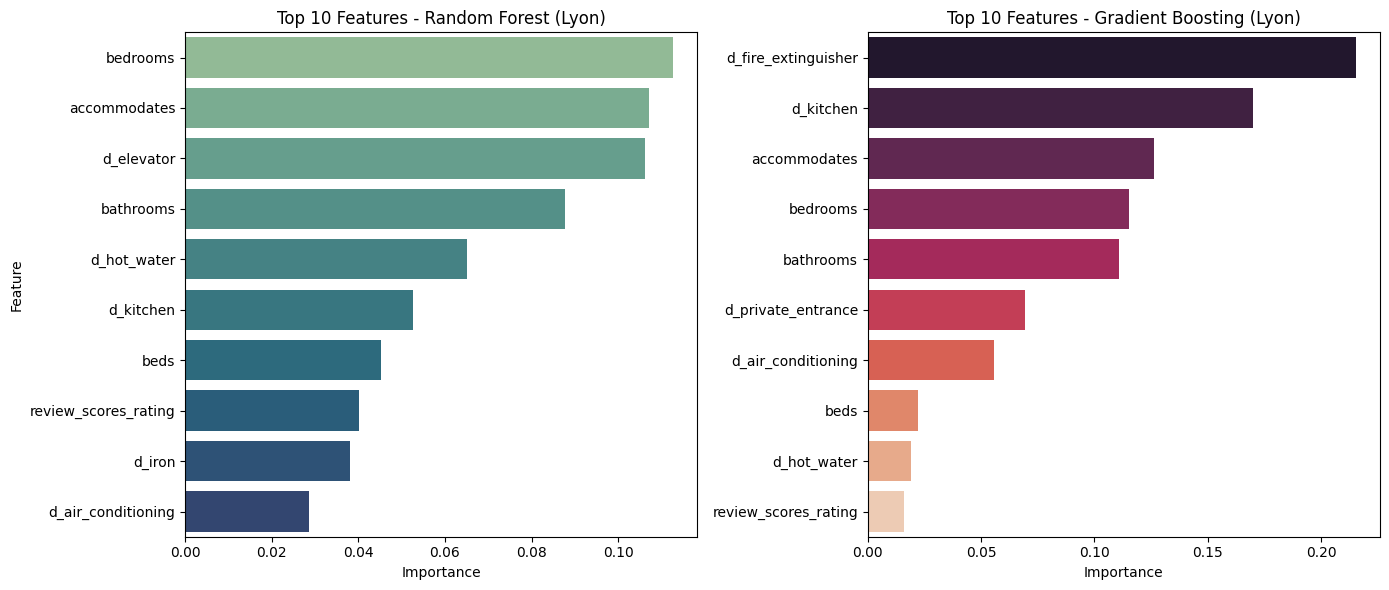

In [ ]:


rf_importance_L = pd.Series(model_rf.feature_importances_, index=valid_features).sort_values(ascending=False)
top_rf_L = rf_importance_L.head(10).reset_index()
top_rf_L.columns = ["Feature", "RF Importance"]

gb_importance_L = pd.Series(model_gb.feature_importances_, index=valid_features).sort_values(ascending=False)
top_gb_L = gb_importance_L.head(10).reset_index()
top_gb_L.columns = ["Feature", "GBR Importance"]

importance_compare_L = pd.merge(top_rf_L, top_gb_L, on="Feature", how="outer").fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=top_rf_L, x="RF Importance", y="Feature", ax=axes[0], palette="crest")
axes[0].set_title("Top 10 Features - Random Forest (Lyon)")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

sns.barplot(data=top_gb_L, x="GBR Importance", y="Feature", ax=axes[1], palette="rocket")
axes[1].set_title("Top 10 Features - Gradient Boosting (Lyon)")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


### Model Comparison and Interpretation (Lyon vs. Paris Q1)

The five predictive models were retrained and evaluated on the Lyon dataset to assess spatial generalizability. The results are compared below with the Paris Q1 benchmark to explore consistency across cities.

####  Lyon Results Summary

| Model                            | Test RMSE | R²       | Time (s) |
|----------------------------------|-----------|----------|----------|
| Random Forest                    | **136.11**| **0.750**| 2.16     |
| Gradient Boosting               | 200.48    | 0.459    | 0.48     |
| MLP Regressor                   | 222.88    | 0.331    | 1.76     |
| Final OLS (LASSO-selected)      | 254.57    | 0.127    | 0.00     |
| LASSO                           | 256.38    | 0.115    | 0.05     |

####  Interpretation:

- **Random Forest** clearly outperformed all other models in Lyon, achieving both the lowest RMSE (≈136) and the highest R² (0.75), indicating strong predictive power and excellent model fit in this city.
- **Gradient Boosting** and **MLP Regressor** performed moderately well, though with lower R² and higher RMSE compared to Random Forest. Their performance appears less stable in this new geographic setting.
- **Linear models** (LASSO and Final OLS with LASSO-selected features) performed poorly, with very low R² scores (≈0.11–0.13). This suggests that the linear relationships captured in Paris do not translate well to the Lyon market.

---

### Comparison to Paris Q1

| Metric        | Best in Paris Q1       | Best in Lyon           | Observation                                       |
|---------------|------------------------|-------------------------|---------------------------------------------------|
| Test RMSE     | OLS / LASSO (≈163)     | Random Forest (≈136)   | Nonlinear models outperform linear ones in Lyon. |
| R² Score      | Random Forest (~0.44)  | Random Forest (~0.75)  | Higher overall fit in Lyon, especially for RF.   |
| Linear Models | Competitive            | Weak                   | Linear models do not generalize well to Lyon.    |

####  Conclusion:

The Lyon results highlight the importance of model flexibility in capturing geographic differences in Airbnb pricing. While **linear models worked well in Paris**, they **underperform in Lyon**, where **Random Forest** stands out as the most robust and transferable approach. This suggests that **city-specific pricing patterns** may require adaptive models capable of handling local complexities.
